In [1]:
from ZilongCode.utils import find_sleep_intervals, find_REM_interval
from src.load_data import load_sleep_data
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import hilbert
from scipy.signal import gaussian
from ZilongCode.utils import bandpassfilter
import pandas as pd
from scipy.ndimage import gaussian_filter
import matplotlib.gridspec as gridspec

In [2]:
#load data
epoch_key = ('bon', 8, 3)
brain_areas = ['CA1', 'CA2', 'CA3']
exclude_interneuron_spikes = True
data = load_sleep_data(epoch_key, brain_areas=brain_areas, exclude_interneuron_spikes=exclude_interneuron_spikes)


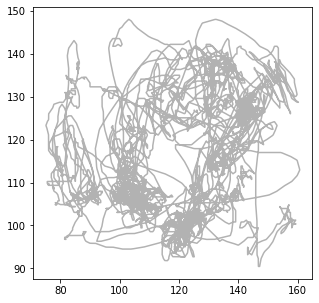

In [3]:
#plot the position of the animal
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plt.plot(data['position_info'].x_position, data['position_info'].y_position, 'k', alpha=0.3)

### get candidate sleep periods with speed < 4 cm/s, preceded by 60 s with no movement > 4 cm/s.  

In [4]:
#get the speed interval
speed = data['position_info'].speed
is_test, valid_durations, valid_intervals = find_sleep_intervals(speed, sleep_duration_threshold=60, lowspeed_threshold=4)
#print the speed interval
valid_intervals

[[Timedelta('0 days 00:48:50.391600'), Timedelta('0 days 00:57:23.855600')],
 [Timedelta('0 days 00:57:59.577600'), Timedelta('0 days 00:59:27.089600')]]

### filter out REM sleep periods according to LFP signal in one example CA1 tetrode.

In [5]:
lfps = data['lfps']

tetrode_info = data['tetrode_info']
CA1_areas = ['CA1']
is_brain_areas = (
    tetrode_info.area.astype(str).str.upper().isin(CA1_areas))

#find lfps in CA1 according to is_brain_areas
CA1_lfps = lfps.loc[:, is_brain_areas.values]

In [6]:
#get CA1_lfps in valid_intervals, and store the results in a dictionary with keys 
CA1_lfps_valid = {}
for  i in range(len(valid_intervals)):
    selected_lfps = CA1_lfps.loc[valid_intervals[i][0]:valid_intervals[i][1], :]
    selected_lfps = selected_lfps.reset_index(drop=True).set_index(selected_lfps.index / np.timedelta64(1, "s"))
    CA1_lfps_valid[i] = selected_lfps

In [7]:
#for each piece of lfp signal, get the Hilbert amplitude (smoothed with a Gaussian kernel, sigma=1 second) of theta (5-11 Hz)

def get_power(lfp, sampling_frequency=500, band=[5, 11]):
    """Returns filtered amplitude.
    Parameters
    ----------
    lfp : pandas.Series
    sampling_frequency : float, optional
    band : list [5, 11] is theta band; whereas [1, 4] is alpha band
    Returns
    -------
    filtered_amplitude : pandas.Series
    """
    lfp = lfp.dropna()
    
    #band pass filter the lfp signal 
    bandpass_lfp = bandpassfilter(lfp, lowcut=band[0], highcut=band[1], fs=sampling_frequency)

    analytic_signal = hilbert(bandpass_lfp)
    amplitude_envelope = np.abs(analytic_signal)

    #smooth the amplitude with a Gaussian kernel, sigma = 1 second, which equals to 1000 points
    amplitude_envelope = pd.DataFrame(amplitude_envelope, index=lfp.index)
    #filtered_amplitude = amplitude_envelope.rolling(1000, win_type='gaussian', center=True, min_periods=1).mean(std=100)
    
    return amplitude_envelope

def get_theta2alpha_ratio(lfp, thetaband=[5,11], alphaband=[1,4]):
    '''
    get the theta/alpha ratio    
    Input:
        lfp: the lfp signal
        thetaband: the theta band
        alphaband: the alpha band
    Output:
        theta/alpha ratio
    '''
    
    lfp = lfp.dropna()
    #get the theta power and alpha power
    theta_power = get_power(lfp, sampling_frequency=500, band=thetaband)
    alpha_power = get_power(lfp, sampling_frequency=500, band=alphaband)
    #get the theta/alpha ratio
    theta2alpha_ratio = theta_power/alpha_power
    
    #Gaussian smooth the ratio with std=500 using gaussian_filter
    theta2alpha_ratio = gaussian_filter(theta2alpha_ratio, sigma=500)
    
    ##to pd dataframe
    theta2alpha_ratio = pd.DataFrame(theta2alpha_ratio, index=lfp.index)
    return theta2alpha_ratio
    

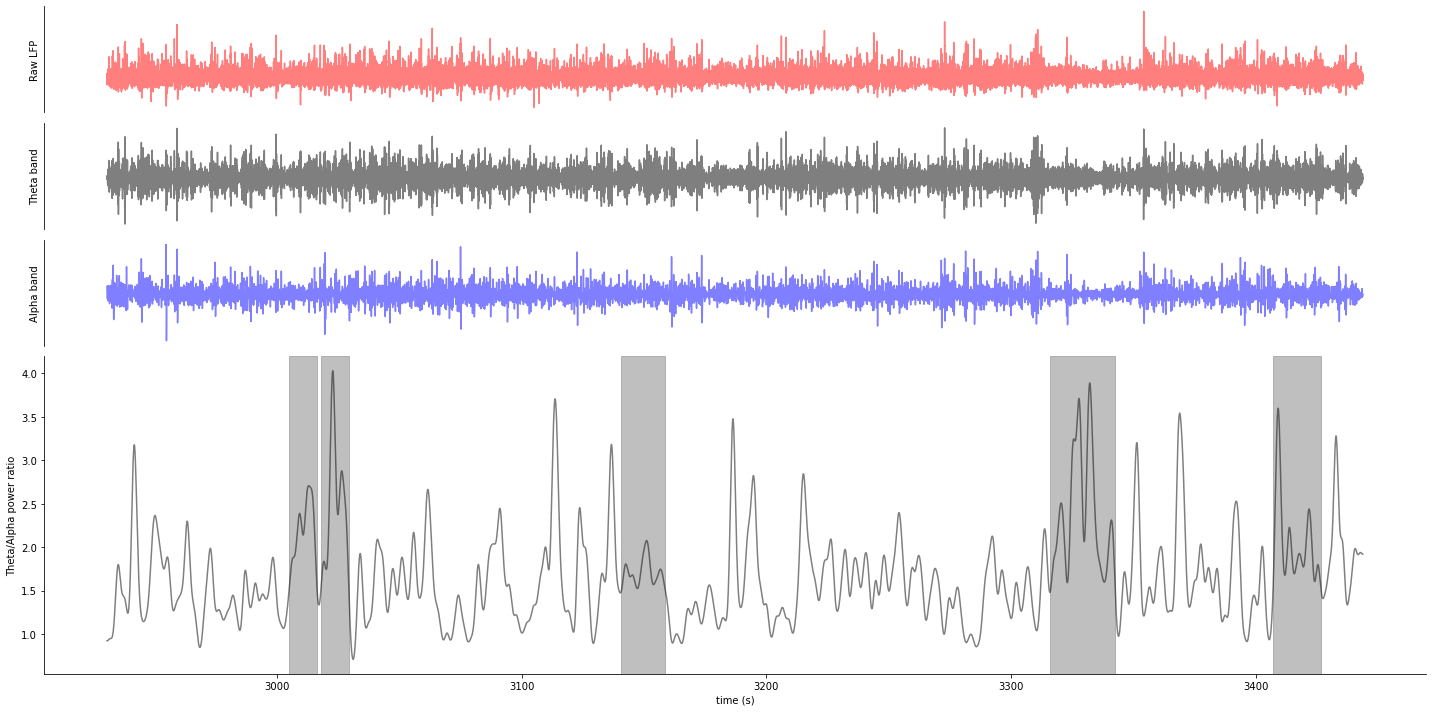

In [9]:
tetrode_lfp_0 = CA1_lfps_valid[0].iloc[:, 0]
tetrode_lfp_0.dropna()

#plot everything with background color white
fig = plt.figure(figsize=(20, 10), facecolor='white') 
#make subplots height as 1:1:1:3
gs = gridspec.GridSpec(4, 1, height_ratios=[1, 1, 1, 3])

ax0 = plt.subplot(gs[0, 0])
ax0.plot(tetrode_lfp_0, 'r', alpha=0.5)
ax0.set_ylabel('Raw LFP')
ax0.set_xticks([])
ax0.set_yticks([])
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
   
#get the theta band filter signal
tetrode_lfp_0_theta = bandpassfilter(tetrode_lfp_0, lowcut=5, highcut=11, fs=500)
tetrode_lfp_0_theta = pd.DataFrame(tetrode_lfp_0_theta, index=tetrode_lfp_0.index)
ax1 = plt.subplot(gs[1, 0])   
ax1.plot(tetrode_lfp_0_theta, 'k', alpha=0.5)
ax1.set_ylabel('Theta band')
#ax off ticks off box off
ax1.set_xticks([])
ax1.set_yticks([])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

#get the alpha band filter signal
tetrode_lfp_0_alpha = bandpassfilter(tetrode_lfp_0, lowcut=1, highcut=4, fs=500)
tetrode_lfp_0_alpha = pd.DataFrame(tetrode_lfp_0_alpha, index=tetrode_lfp_0.index)
ax2 = plt.subplot(gs[2, 0])   
ax2.plot(tetrode_lfp_0_alpha, 'b', alpha=0.5)
ax2.set_ylabel('Alpha band')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

gaussian_smoothed_theta2alpha_ratio = get_theta2alpha_ratio(tetrode_lfp_0, thetaband=[5,11], alphaband=[1,4])
#find all the intervals when the ratios is larger than 1.5 and the duration is more than 10 seconds
is_REM, REM_durations, REM_intervals = find_REM_interval(gaussian_smoothed_theta2alpha_ratio, REMduration=10, REMthreshold=1.5)
ax3 = plt.subplot(gs[3, 0])   
ax3.plot(gaussian_smoothed_theta2alpha_ratio, 'k', alpha=0.5, label='theta/alpha ratio')
#mark the REM intervals as grey
for i in range(len(REM_intervals)):
    ax3.axvspan(REM_intervals[i][0], REM_intervals[i][1], color='grey', alpha=0.5)

ax3.set_xlabel('time (s)')
ax3.set_ylabel('Theta/Alpha power ratio')
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()

Text(0, 0.5, 'alpha band power')

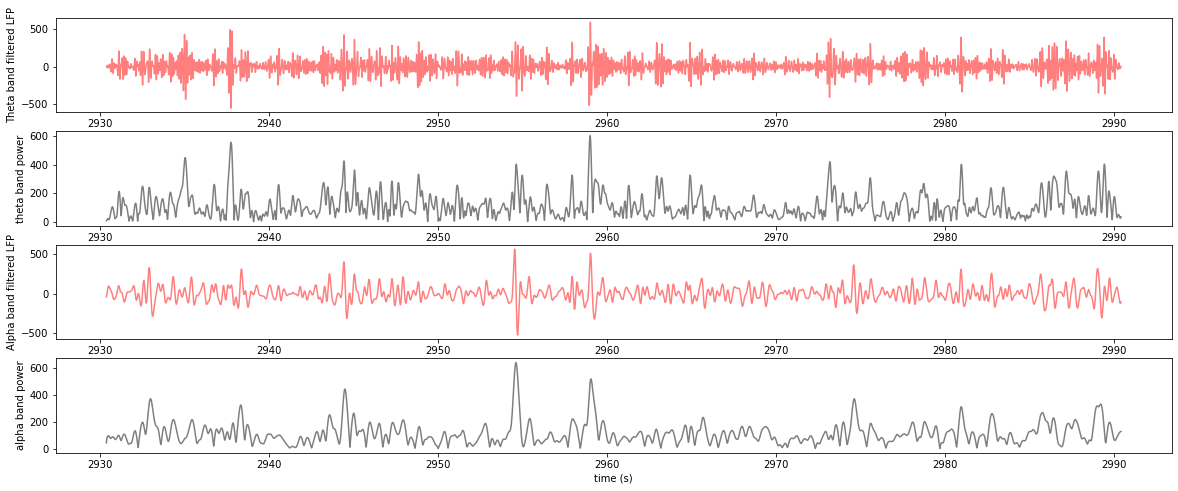

In [10]:
#get theta and alpha band power and plot the power
fig, axs = plt.subplots(4, 1, figsize=(20, 8))
axs[0].plot(tetrode_lfp_0_theta.iloc[:30000], 'r', alpha=0.5, label='raw signal')
axs[0].set_xlabel('time (s)');axs[0].set_ylabel('Theta band filtered LFP')
tetrode_lfp_0_theta_power = get_power(tetrode_lfp_0, sampling_frequency=500, band=[5, 11])
axs[1].plot(tetrode_lfp_0_theta_power.iloc[:30000], 'k', alpha=0.5, label='theta band power')
axs[1].set_xlabel('time (s)');axs[1].set_ylabel('theta band power')
axs[2].plot(tetrode_lfp_0_alpha.iloc[:30000], 'r', alpha=0.5, label='raw signal')
axs[2].set_xlabel('time (s)');axs[2].set_ylabel('Alpha band filtered LFP')
tetrode_lfp_0_alpha_power = get_power(tetrode_lfp_0, sampling_frequency=500, band=[1, 4])
axs[3].plot(tetrode_lfp_0_alpha_power.iloc[:30000], 'k', alpha=0.5, label='alpha band power')
axs[3].set_xlabel('time (s)');axs[3].set_ylabel('alpha band power')



### Average the theta to alpha ratio of Hilbert amplitudes over all CA1 tetrodes



In [11]:
all_ratio4interval = []
for key in CA1_lfps_valid.keys():
    
    ca1_lfps_interval_i = CA1_lfps_valid[key]

    #initial a panda dataframe to store the theta/alpha ratio for each interval
    ratio4interval = pd.DataFrame(index=ca1_lfps_interval_i.index)
    for j in range(ca1_lfps_interval_i.shape[1]):
        lfp = ca1_lfps_interval_i.iloc[:, j]
        #get the theta/alpha ratio
        theta2alpha_ratio = get_theta2alpha_ratio(lfp, thetaband=[5,11], alphaband=[1,4])
        #add the ratio to the ratio4interval dataframe to j column
        ratio4interval[j] = theta2alpha_ratio
    
    #get the mean ratio for each time point
    mean_ratio4interval = ratio4interval.mean(axis=1)
    
    #append
    all_ratio4interval.append(mean_ratio4interval)
    
        

Text(0, 0.5, 'Averaged Theta/Alpha power ratio over all CA1 channels')

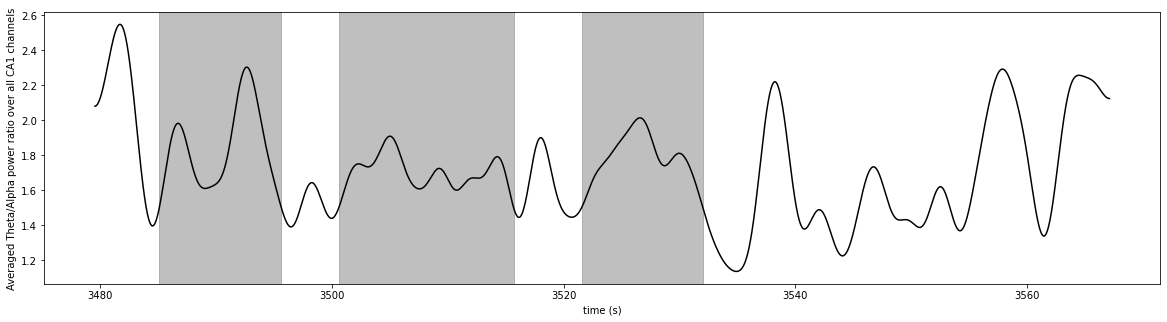

In [12]:
is_REM, REM_durations, REM_intervals = find_REM_interval(mean_ratio4interval, REMduration=10, REMthreshold=1.5)

#plot mean_ratio4interval
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.plot(mean_ratio4interval, 'k', alpha=1, label='theta/alpha ratio')
#add the REM intervals as grey
for i in range(len(REM_intervals)):
    ax.axvspan(REM_intervals[i][0], REM_intervals[i][1], color='grey', alpha=0.5)
ax.set_xlabel('time (s)')
ax.set_ylabel('Averaged Theta/Alpha power ratio over all CA1 channels')



### show results including running periods together

In [13]:
#First, get the aggregated hippocampal LFP across all CA1, CA2, CA3 channels
lfps = data['lfps']
tetrode_info = data['tetrode_info']
CA123_areas = ['CA1', 'CA2', 'CA3']
is_brain_areas = (
    tetrode_info.area.astype(str).str.upper().isin(CA123_areas))

#find lfps in CA1 according to is_brain_areas
CA123_lfps = lfps.loc[:, is_brain_areas.values]

#processing the lfps
for i in range(CA123_lfps.shape[1]):
    #square the lfp signal
    CA123_lfps.iloc[:, i] = CA123_lfps.iloc[:, i]**2
    #Gaussian smooth the lfp signal with sigma=150
    CA123_lfps.iloc[:, i] = gaussian_filter(CA123_lfps.iloc[:, i], sigma=150)
    #take square root of the lfp signal
    CA123_lfps.iloc[:, i] = np.sqrt(CA123_lfps.iloc[:, i])
    #z-score the lfp signal
    CA123_lfps.iloc[:, i] = (CA123_lfps.iloc[:, i] - CA123_lfps.iloc[:, i].mean())/CA123_lfps.iloc[:, i].std()

#sum the lfp over all columns
CA123_lfps_sum = CA123_lfps.sum(axis=1)
#z-score the sum lfp to get the aggregate hippocampal LFP signal
aggregate_hpc_lfp = (CA123_lfps_sum - CA123_lfps_sum.mean())/CA123_lfps_sum.std()

In [14]:
#Second, get the averaged theta/alpha ratio across all CA1 channels
lfps = data['lfps']

tetrode_info = data['tetrode_info']
CA1_areas = ['CA1']
is_brain_areas = (
    tetrode_info.area.astype(str).str.upper().isin(CA1_areas))

#find lfps in CA1 according to is_brain_areas
CA1_lfps = lfps.loc[:, is_brain_areas.values]
#change index to seconds
CA1_lfps = CA1_lfps.reset_index(drop=True).set_index(CA1_lfps.index / np.timedelta64(1, "s"))
theta2alpha_ratios = pd.DataFrame(index=CA1_lfps.index)
thetapowers = pd.DataFrame(index=CA1_lfps.index)
alphapowers = pd.DataFrame(index=CA1_lfps.index)
for j in range(CA1_lfps.shape[1]):
    lfp = CA1_lfps.iloc[:, j]
    #get theta power
    theta_power = get_power(lfp, sampling_frequency=500, band=[5, 11])
    thetapowers[j] = theta_power**2
    #get alpha power
    alpha_power = get_power(lfp, sampling_frequency=500, band=[1, 4])
    alphapowers[j] = alpha_power**2
    #get the theta/alpha ratio
    theta2alpha_ratio = get_theta2alpha_ratio(lfp, thetaband=[5,11], alphaband=[1,4])
    #add the ratio to the ratio4interval dataframe to j column
    theta2alpha_ratios[j] = theta2alpha_ratio

#get the mean theta power
mean_theta_power = thetapowers.mean(axis=1)
#get the mean alpha power
mean_alpha_power = alphapowers.mean(axis=1)
#get the mean ratio for each time point
meanratio = theta2alpha_ratios.mean(axis=1)


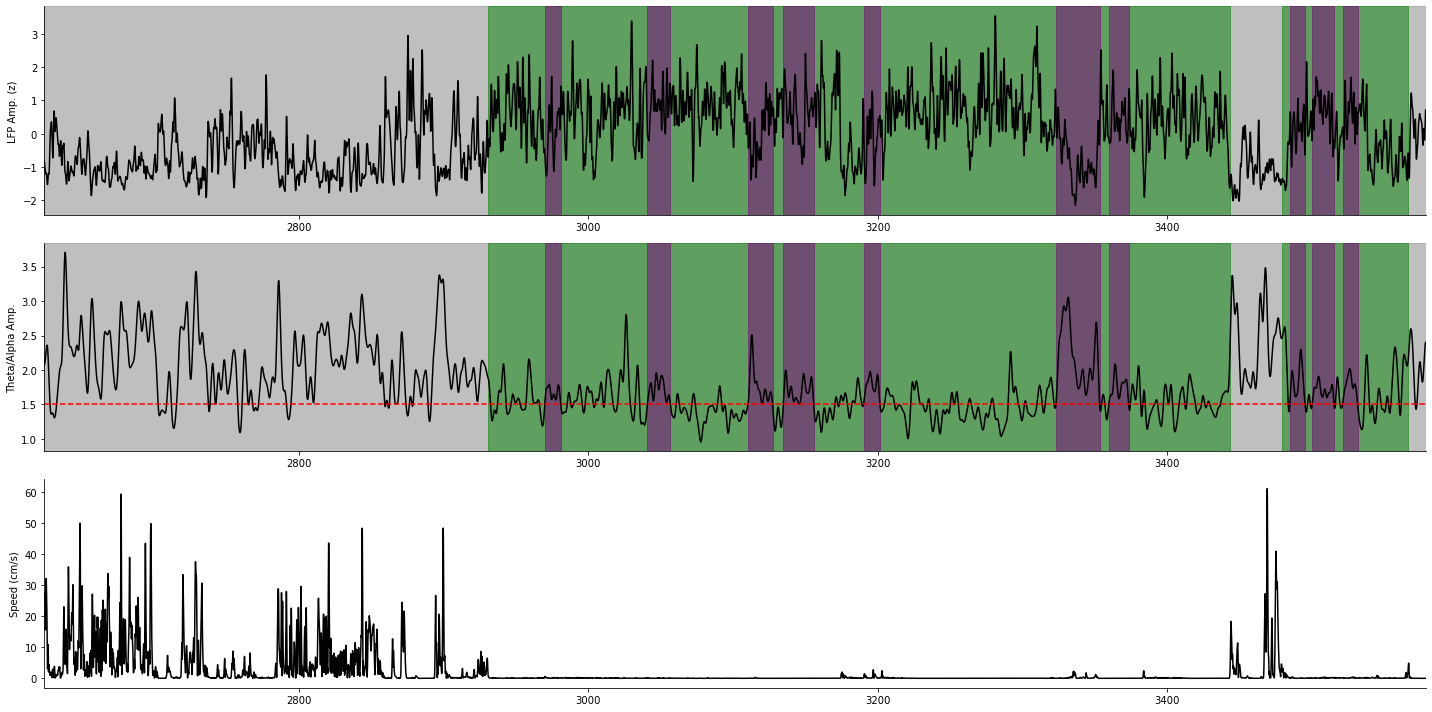

In [15]:
#plot 
fig, axs = plt.subplots(3, 1, figsize=(20, 10))

# 0, plot the aggregate_hpc_lfp
axs[0].plot(aggregate_hpc_lfp.index/np.timedelta64(1, "s"), aggregate_hpc_lfp, 'k', alpha=1, label='aggregate_hpc_lfp')
axs[0].set_ylabel('LFP Amp. (z)')

# # 1, plot the theta power and alpha power in different colors
# #gauusian smooth the theta power with sigma=500
# theta_power = gaussian_filter(mean_theta_power, sigma=500)
# #to pd dataframe
# theta_power = pd.DataFrame(theta_power, index=mean_theta_power.index)
# #gauusian smooth the alpha power with sigma=500
# alpha_power = gaussian_filter(mean_alpha_power, sigma=500)
# #to pd dataframe    
# alpha_power = pd.DataFrame(alpha_power, index=mean_alpha_power.index)
# axs[1].plot(theta_power, 'orange', alpha=1, linewidth=2, label='theta power')
# axs[1].plot(alpha_power, 'lightblue', alpha=1, linewidth=2, label='alpha power')
# axs[1].set_ylabel('Ave. Theta Power')
# #legend
# axs[1].legend()

# 1, plot the theta/alpha ratio
axs[1].plot(meanratio, 'k', alpha=1, label='theta/alpha ratio')
#add REMthreshold as a horizontal line
axs[1].axhline(y=1.5, color='r', linestyle='--', label='REM threshold')
#mark all as grey to both axs[0] and axs[1] first , this is the background color
axs[0].axvspan(meanratio.index[0], meanratio.index[-1], color='grey', alpha=0.5)
axs[1].axvspan(meanratio.index[0], meanratio.index[-1], color='grey', alpha=0.5)

# 1.1: mark the valid_intervals as green 

#change valid_intervals to seconds
valid_intervals_sec = []
for i in range(len(valid_intervals)):
    valid_intervals_sec.append([valid_intervals[i][0]/np.timedelta64(1, "s"), valid_intervals[i][1]/np.timedelta64(1, "s")])
#add intervals to axs[0] and axs[1]
for i in range(len(valid_intervals_sec)):
    axs[0].axvspan(valid_intervals_sec[i][0], valid_intervals_sec[i][1], color='green', alpha=0.5)
    axs[1].axvspan(valid_intervals_sec[i][0], valid_intervals_sec[i][1], color='green', alpha=0.5)
    
# # 1.2 mark the REM intervals as purple using all_ratio4interval to both axs[0] and axs[1]
for ratio4interval in all_ratio4interval:
    is_REM, REM_durations, REM_intervals = find_REM_interval(ratio4interval, REMduration=10, REMthreshold=1.5)
    for i in range(len(REM_intervals)):
        axs[0].axvspan(REM_intervals[i][0], REM_intervals[i][1], color='purple', alpha=0.5)
        axs[1].axvspan(REM_intervals[i][0], REM_intervals[i][1], color='purple', alpha=0.5)
        
axs[1].set_ylabel('Theta/Alpha Amp.')


# 2, plot the speed
speed = data['position_info'].speed
axs[2].plot(speed.index/np.timedelta64(1, "s"), speed, 'k', alpha=1, label='speed')
axs[2].set_ylabel('Speed (cm/s)')

#set xlim meanratio.index[0] and meanratio.index[-1] for all subplots
for ax in axs:
    ax.set_xlim(meanratio.index[0], meanratio.index[-1])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
plt.tight_layout()



Text(0, 0.5, 'Probability')

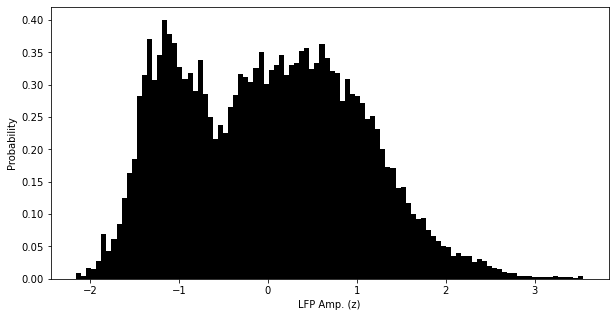

In [16]:
#get a histogram (nrmalized probability) of the aggregate_hpc_lfp
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist(aggregate_hpc_lfp, bins=100, density=True, color='k')
ax.set_xlabel('LFP Amp. (z)')
ax.set_ylabel('Probability')
